In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from dataset.sentinel import *
from models.lstm_ae import *
from models.conv_ae import *
import torch
import random
from torchvision.transforms import transforms as T
from config import *
from esa.utils import *
from esa.conv_utils import *

import platform

import numpy as np

architecture = 'conv_ae'

In [2]:
model_list = os.listdir(model_results+ '{}/'.format(architecture))
for ix, mn in enumerate(model_list):  
    print('model num {}: {}'.format(ix,model_list[ix]))

model num 0: conv_ae_sl_16_fn_32_ks_3.pth


In [3]:
selected_model = 0
print(model_list[selected_model])
model_name = model_list[selected_model].split('.')[0]

conv_ae_sl_16_fn_32_ks_3.pth


In [4]:
try:
    sm = str(torch.cuda.get_device_capability())
    sm = ''.join((sm.strip('()').split(',')[0], sm.strip('()').split(',')[1])).replace(' ', '')
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:0" if use_cuda and sm in torch.cuda.get_arch_list() else "cpu")
except:
    device='cpu'

In [5]:
checkpoint  = torch.load(model_results+ '{}/'.format(architecture) + '/' + model_list[selected_model]
                         , map_location=device)
params_conf = checkpoint['param_conf']

In [6]:
cols = params_conf['columns']
sequence_length = params_conf['sequence_length']
batch_size = params_conf['batch_size']
predict = params_conf['predict']

out_window = params_conf['out_window']

n_features = params_conf['n_features']
scaled = params_conf['scaled']
sampling_rate = params_conf['sampling_rate']

columns_subset = params_conf['columns_subset']
dataset_subset = params_conf['dataset_subset']

dataset = params_conf['dataset']
train_val_split = params_conf['train_val_split']

target = params_conf['target']
batch_size = params_conf['batch_size']
sequence_length = params_conf['sequence_length']
out_window = params_conf['out_window']
predict = params_conf['predict']
activation = params_conf['activation']
kernel_size = params_conf['kernel_size']
filter_num = params_conf['filter_num']
latent_dim = params_conf['latent_dim']
n_layers = params_conf['n_layers']

In [7]:
model = CONV_AE(in_channel=1,heigth=sequence_length, width=len(columns),
                        kernel_size=kernel_size, filter_num=filter_num,
                 latent_dim=latent_dim, \
        n_layers=n_layers, activation = activation).to(device)

model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
par_nums = count_parameters(model)
print('number of params', par_nums)

Initializing conv2d weights with Kaiming He normal
Initializing conv2d weights with Kaiming He normal
number of params 12335


In [8]:
transform = T.Compose([T.ToTensor()])
dataset_name = os.path.join(data_path.strip('..'), "all_2016-2018_clean_std_4s.pkl")
df_train, df_test, train_iter, test_iter = \
read_dataset_conv(dataset_name, params_conf['scaled'],params_conf['columns_subset']
                  , params_conf['dataset_subset'], params_conf['columns'], 
                 params_conf['train_val_split'], params_conf['sequence_length']
                  ,params_conf['sequence_length'],  predict=False,
                 batch_size=4, transform=transform )

In [ ]:
compute_mse_val_loss = True

In [ ]:
mse_val_loss_list = []
criterion = nn.MSELoss()
if compute_mse_val_loss:
    for i, (x,y) in enumerate(test_iter):
        yo = model(x)
        mse_val_loss_list.append(criterion(yo, x).item())
    mse_val_loss = np.mean(mse_val_loss_list)
    print(mse_val_loss)

In [9]:
num_batch = 20
inject_anomalies = False

if inject_anomalies:
    x, shift = unrolling_batches_conv_with_anomalies(num_batch=num_batch, test_iter=test_iter, sigma=3,
                             sequence_length=sequence_length, cols=cols, shift = None)
else:
    x, shift = unrolling_batches_conv(num_batch=num_batch, test_iter=test_iter, 
                         sequence_length=sequence_length, cols=cols, shift = None)
    
print('time horizon', num_batch*params_conf['sequence_length'])

time horizon 320


In [10]:
yo = model(x.to(device)).squeeze()
if inject_anomalies:
    ya = model(xa.to(device)).squeeze()
save = False

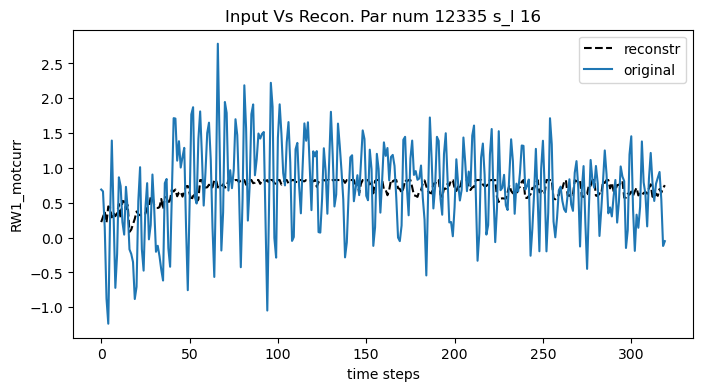

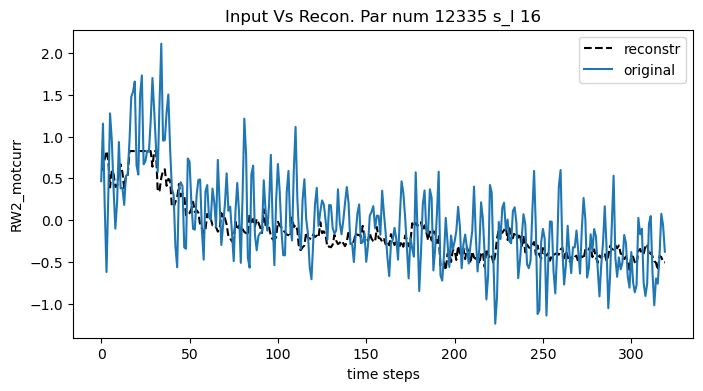

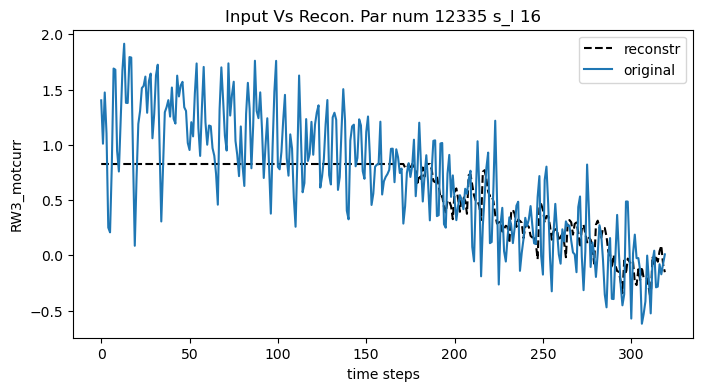

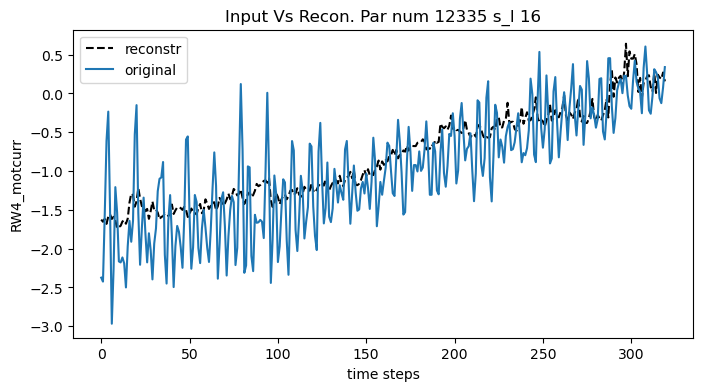

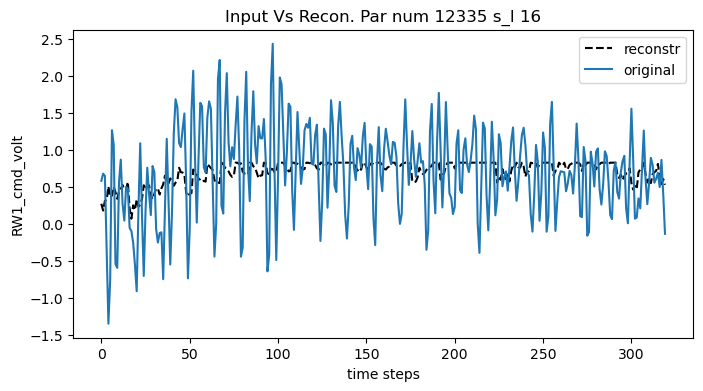

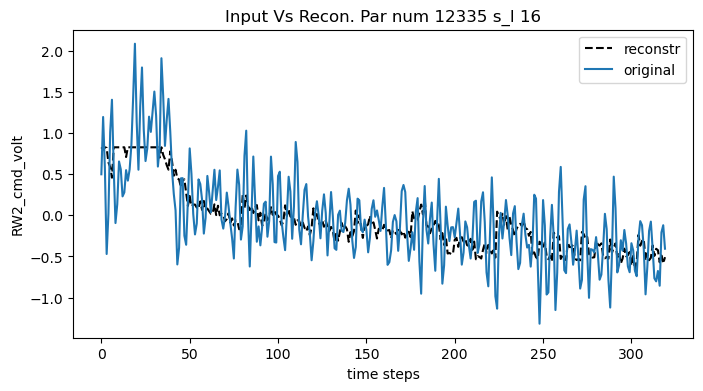

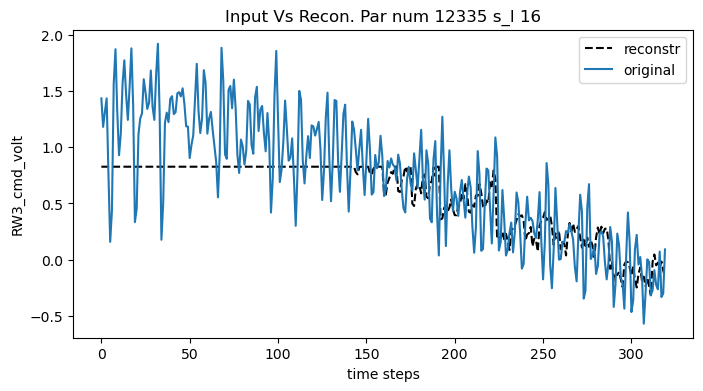

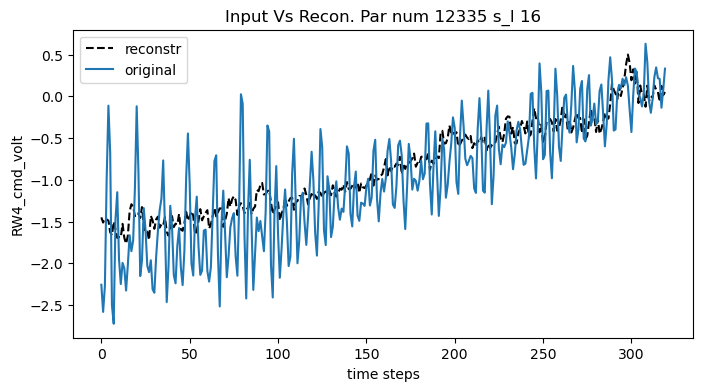

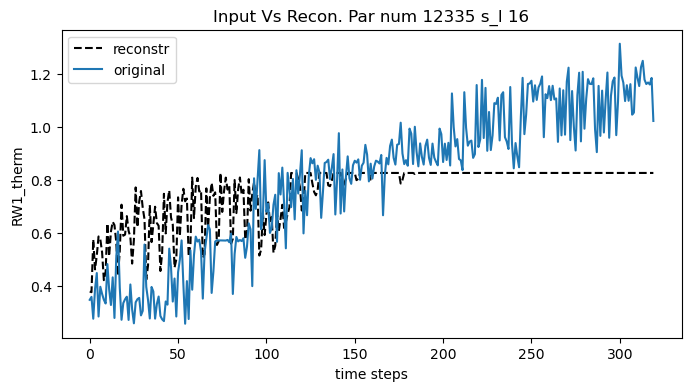

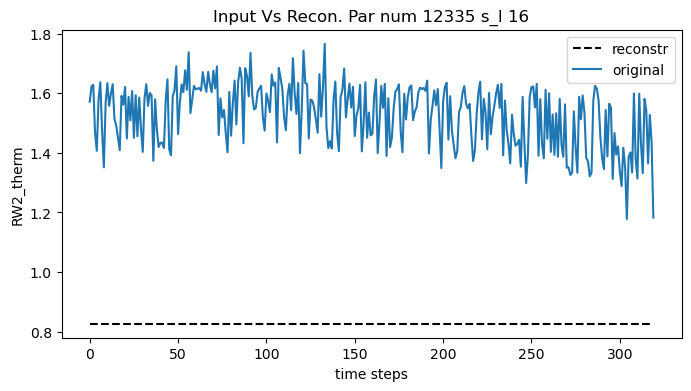

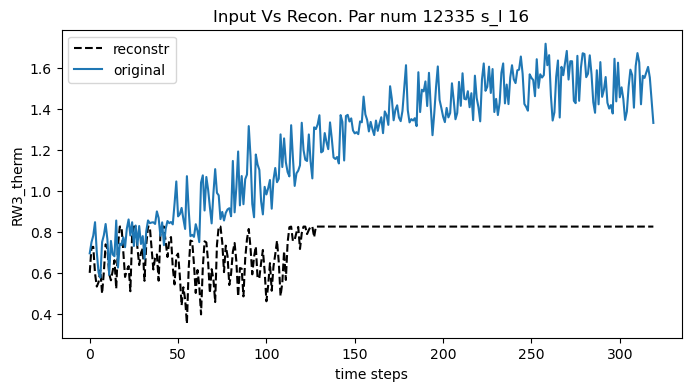

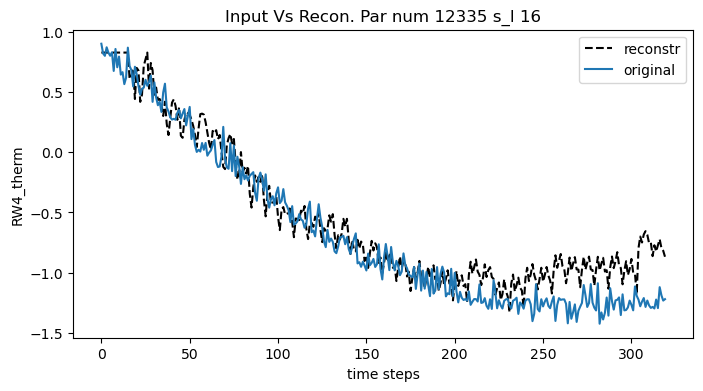

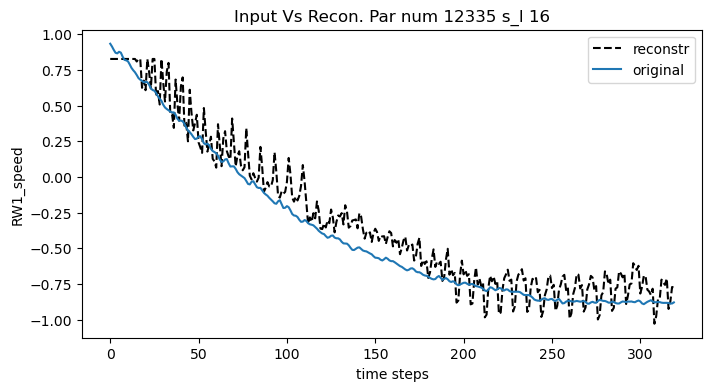

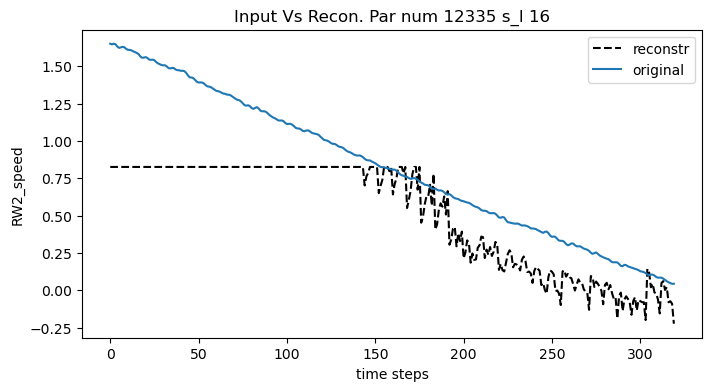

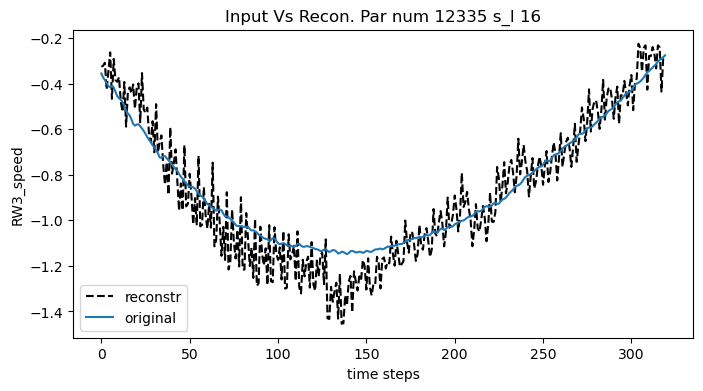

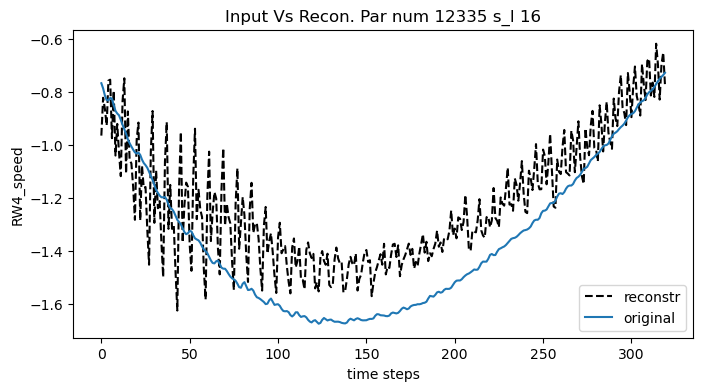

In [12]:
x_plot = x.squeeze().to(device)

show_results(x_plot , yo, cols, model_name, params_conf
     , par_nums, shift, num_batch,arch=architecture,save=False)